# eqGAN Training Notebook

An attempt to perform automatic music mastering using a Generative Adversarial Network

### Make sure that these constants are set correctly!

In [18]:
# Constants
USING_GPU = True
AVAILABLE_GPUS="0,1,2,3,4,5"
CUDANO = 0

D_LR = 1e-3
G_LR = 1e-3
EPOCHS = 10
IS_DIRECT = True # Direct or Indirect Reconstruction (See Paper for more details)
SAMPLE_LENGTH = 110229 # Less than 661794


RUN_NAME = 'gan_run_6'

You should (hopefully) be able to run the rest of the cells without editing anything

In [2]:
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt
import numpy as np

/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Download the dataset

In [12]:
# Construct a torch.utils.data.Dataset and DataLoader
gtzan_data = torchaudio.datasets.GTZAN('.', download=False)

def collate_fn(batch):
    # Takes in a list (batch) of samples (waveform, sample_rate, label)
    batch_size = len(batch)
    waveforms = []
    for waveform, sample_rate, label in batch:
        if waveform.size(1) == 661794:
            waveforms.append(waveform)
        elif waveform.size(1) > 661794:
            waveforms.append(waveform[:,:661794])
        else:
            diff = 661794 - waveform.size(1)
            waveforms.append(torch.nn.functional.pad(waveform,(0,diff)))
            
        
    waveform_batch = torch.stack(waveforms, dim=0)
    # Returns a tuple collated with sizes (torch.Size([batch_size, 1, 661794]), )
    return torch.unsqueeze(waveform_batch[0, :, :], 0), sample_rate, label

gtzan_loader = torch.utils.data.DataLoader(gtzan_data, batch_size=10, shuffle=False, num_workers=6, collate_fn=collate_fn)

In [13]:
def visualize_wav(waveform, domain='time'):
    """
    A function to visualize a waveform in the time or frequency domain
    """
    wav = torch.squeeze(waveform, dim=0)
    if domain == 'freq':
        plt.figure(figsize=(50,30))
        specgram = torchaudio.transforms.Spectrogram()(wav)
        plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')
    elif domain == 'time':
        plt.figure()
        plt.plot(wav.t().numpy())
    else:
        print('Invalid domain')

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: 22050


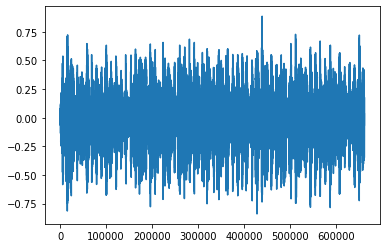

In [14]:
# Show a single example
example_wav, example_sr = None, None
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))
    example_wav, example_sr = waveform[0,:,:], sample_rate

    visualize_wav(waveform[0,:,:])
    break

### Implement EQ operations

In [15]:
# Define the EQ transform
from scipy.stats import loguniform

class RandomEQ(object):
    """EQ the waveform in a sample randomly.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, sample_rate):
        assert isinstance(sample_rate, (float, int))
        self.sample_rate = sample_rate
        
        # EQ Constants
        self.FREQ_RANGE = [0.01, 20] # in kHZ
        self.GAIN_RANGE = [-15, 15] # in dB
        self.Q_RANGE = [0.1, 18]

    def __call__(self, waveform, verbose=False):
        # TODO: Make some of these normals
        center_freq = loguniform.rvs(self.FREQ_RANGE[0], self.FREQ_RANGE[1])
        gain = np.random.uniform(self.GAIN_RANGE[0], self.GAIN_RANGE[1])
        Q = np.random.uniform(self.Q_RANGE[0], self.Q_RANGE[1])

        center_freq = 1
        gain = -10
        Q = 1
        
        if verbose:
            print(
                f"Applying random EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

        equalized_waveform = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        ) 

        return equalized_waveform

Shape of waveform: torch.Size([1, 1, 661794])
Sample rate of waveform: 22050


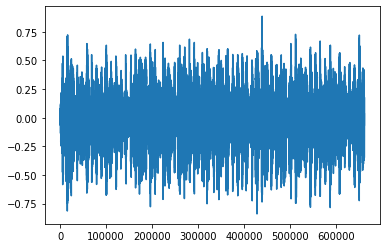

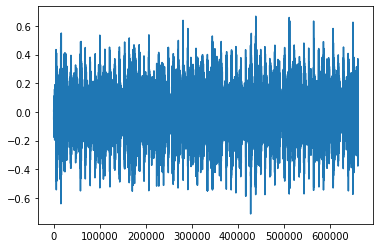

In [16]:
# Show a single example
eq_transform = RandomEQ(example_sr)
for waveform, sample_rate, label in gtzan_loader:
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    visualize_wav(waveform[0,:,:])
    visualize_wav(eq_transform(waveform[0,:,:]))
    break

### Learn an EQ operation

We want to test whether or not we can have a model learn an EQ operation by reconstructing the non-equalized version of the waveform

In [19]:
import os

device = 'cpu'

if USING_GPU:
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]=AVAILABLE_GPUS
    device = f'cuda:{CUDANO}'

if not os.path.exists(f"EQ/{RUN_NAME}"):
    os.mkdir(f"EQ/{RUN_NAME}")

In [20]:
class EQReconstructor(torch.nn.Module):
    def __init__(self, sample_rate, sample_length, direct=False):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.direct = direct
        self.indirect = not direct

        self.synthetic_transform = RandomEQ(self.sample_rate)
        self.indirect_rnn = torch.nn.LSTM(input_size=1, hidden_size=16, num_layers=1)
        self.indirect_linear = torch.nn.Linear(16, 3)
        
        self.direct_rnn = torch.nn.LSTM(input_size=1, hidden_size=64, num_layers=3)
        self.direct_linear = torch.nn.Linear(64, 1)
        
        #self.gain = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_min = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_max = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_mean = torch.nn.parameter.Parameter(torch.tensor(1.0))
        self.gain_rmse = torch.nn.parameter.Parameter(torch.tensor(1.0))

        self.criterion = torch.nn.MSELoss()
        
        self.activation = torch.nn.Tanh()

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, apply a random
        EQ, and then try to reconstruct it
        """
        # print("Pre-processing wav")
        with torch.no_grad():
            equalized_wav = self.synthetic_transform(waveform)

        if self.direct:
            # Run through the rnn
            output, (hn, cn) = self.direct_rnn(equalized_wav)
            
            # Get some stats from the output to figure out how much to boost gain            
            gain = output.min()*self.gain_min + output.max()*self.gain_max + output.mean()*self.gain_mean + torch.pow(output, 2).mean()*self.gain_rmse
            
            # Boost the gain
            reconstructed_wav = self.direct_linear(output)
            
            return reconstructed_wav

        if self.indirect:
            # print("Sharding waveform")
            wav_length = waveform.shape[0]
            num_seconds = 5
            num_shards = int(wav_length / (self.sample_rate*num_seconds)) + 1

            center_freq = torch.tensor(0., requires_grad=True)
            gain = torch.tensor(0., requires_grad=True)
            Q = torch.tensor(0., requires_grad=True)
            for i in range(num_shards):
                # print(f"Running LSTM on shard {i+1}/{num_shards}")
                # Create shard
                start_idx = i*self.sample_rate
                end_idx = (i+1)*self.sample_rate
                if end_idx >= wav_length:
                    end_idx = -1
                shard = equalized_wav[start_idx:end_idx,:,:]

                # Run LTSM
                output, (hn, cn) = self.indirect_rnn(shard)
                preds = self.indirect_linear(hn)

                # Add vals to running sum
                center_freq = center_freq + preds[0,0,0]
                gain = gain + preds[0,0,1]
                Q = Q + preds[0,0,2]

            # Divide by number of runs
            center_freq /= num_shards
            gain /= num_shards
            Q /= num_shards

            print(
                f"Predicted EQ with center frequency of ",
                f"{center_freq} kHZ, gain of {gain} dB, and Q = {Q}"
            )

            return center_freq, gain, Q

    def loss(self, output, waveform):
        """
        Here we define the loss function that the model will try to optimize.
        In this case, a simple reconstruction loss
        """
        if direct:
            reconstructed_wav = output
        if indirect:
            center_freq, gain, Q = output
            reconstructed_wav = torchaudio.functional.equalizer_biquad(
                waveform, self.sample_rate,
                center_freq=center_freq*1e3, gain=gain, Q=Q
            )
        loss = criterion(waveform, reconstructed_wav)
        return loss


In [21]:
criterion = torch.nn.MSELoss()
def loss_function(output, waveform, direct=False):
    """
    Here we define the loss function that the model will try to optimize.
    In this case, a simple reconstruction loss
    """
    if direct:
        reconstructed_wav = output
    if not direct:
        center_freq, gain, Q = output
        reconstructed_wav = torchaudio.functional.equalizer_biquad(
            waveform, self.sample_rate,
            center_freq=center_freq*1e3, gain=gain, Q=Q
        )

    loss = criterion(waveform, reconstructed_wav)
    loss += 0.05*torch.pow(waveform.max() - reconstructed_wav.max(), 2) # Penalize differences in max
    loss += 0.05*torch.pow(waveform.min() - reconstructed_wav.min(), 2)# Penalize differences in min
    return loss

In [22]:
class EQEvaluator(torch.nn.Module):
    def __init__(self, sample_rate, sample_length):
        """
        In the constructor we instantiate the layers
        """
        super().__init__()
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=16, num_layers=1)
        self.classifier = torch.nn.Linear(16, 1)

    def forward(self, waveform):
        """
        In the forward function we accept an input waveform, run it through
        an LSTM, and decide if it's mastered or unmastered
        """
        # Run through the rnn
        output, (hn, cn) = self.rnn(waveform)
        
        # Prediction logit
        logit = torch.squeeze(self.classifier(hn))
        
        return logit

In [23]:
generator = EQReconstructor(sample_rate=22050, sample_length=SAMPLE_LENGTH, direct=IS_DIRECT).to(device) 
discriminator = EQEvaluator(sample_rate=22050, sample_length=SAMPLE_LENGTH).to(device)
gen_optimizer = torch.optim.SGD(generator.parameters(), lr=G_LR)
disc_optimizer = torch.optim.SGD(discriminator.parameters(), lr=D_LR)

bce_loss = torch.nn.BCEWithLogitsLoss()

num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    print("Let's use", num_gpus , "GPUs!")
    generator = torch.nn.DataParallel(generator)
    discriminator = torch.nn.DataParallel(discriminator)
    
for i in range(num_gpus):
    print("Device ", i, torch.cuda.get_device_name(i))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(i)/1024**3,1), 'GB')
    
# print(os.popen("source cuda10.0").read())

# print(os.popen("nvidia-htop.py").read())
# print(os.popen("nvidia-smi").read())

Let's use 6 GPUs!
Device  0 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  1 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  2 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  3 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  4 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Device  5 GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


Epoch 0/10
Training Discriminator on real samples and fake reconstructed samples
Processing batch 1/100


/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/lfs/turing2/0/frg100/gpuvenv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


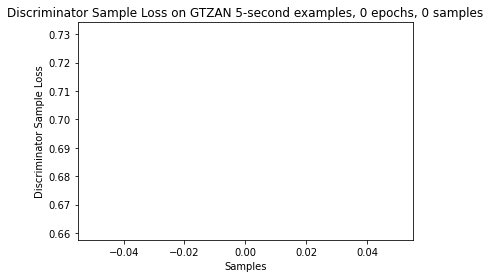

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


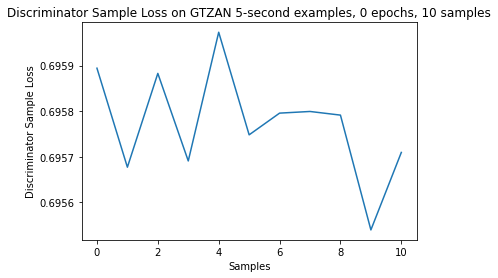

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


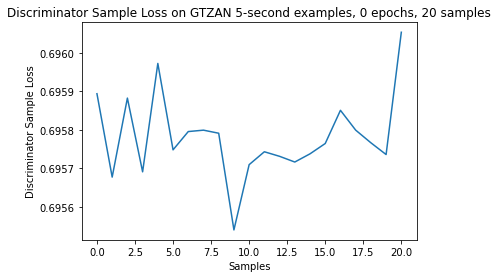

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


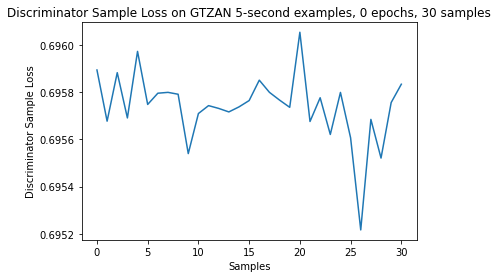

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


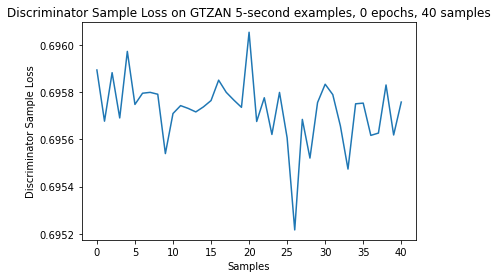

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


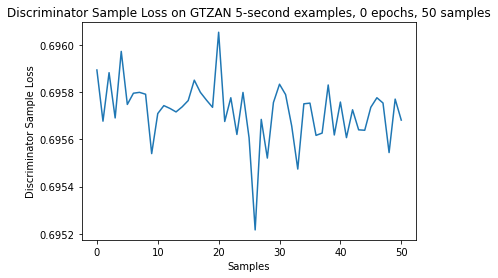

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


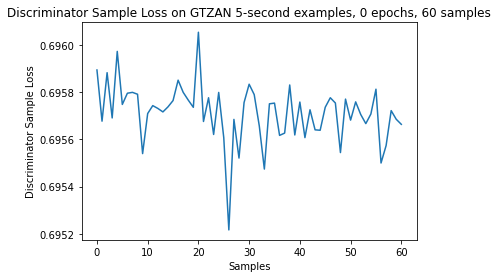

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


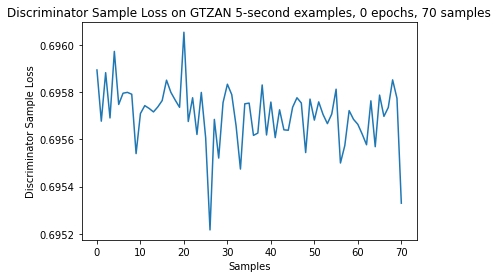

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


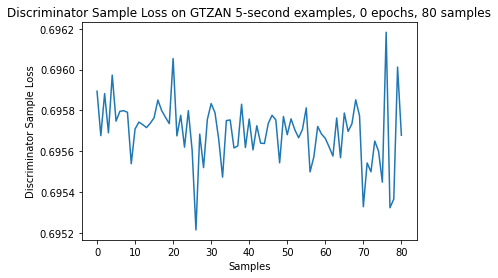

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


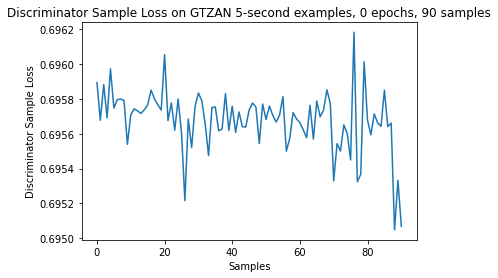

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100


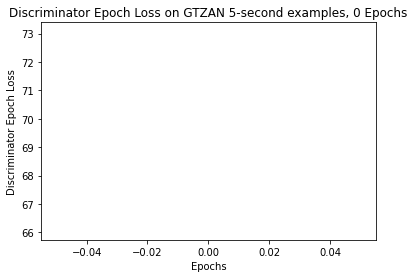

Processing batch 1/100


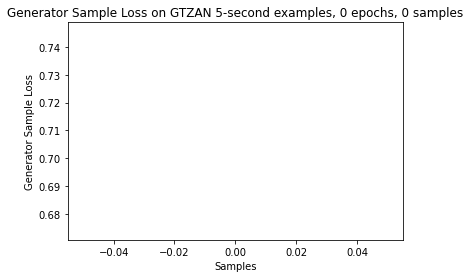

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


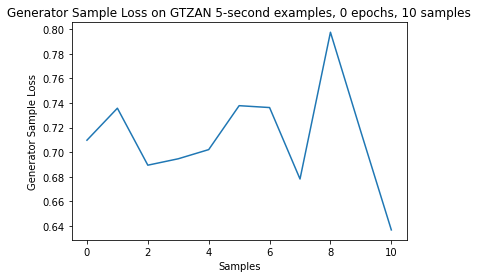

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


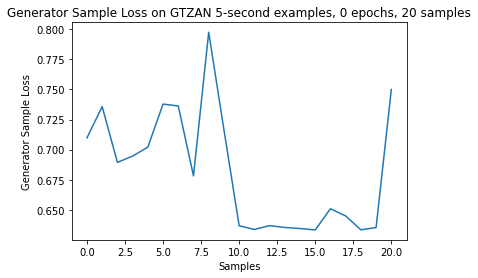

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


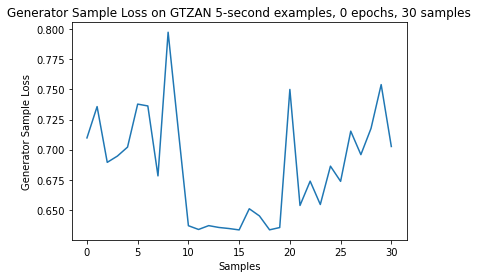

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


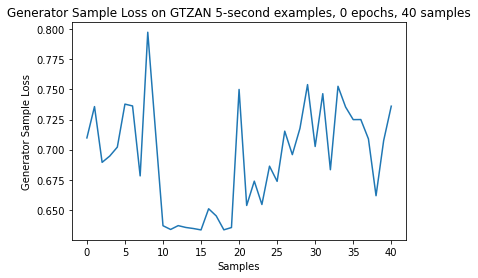

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


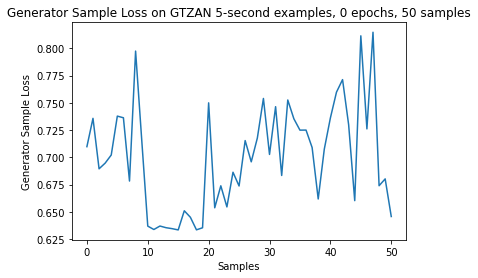

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


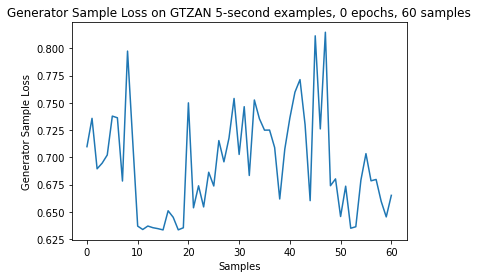

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


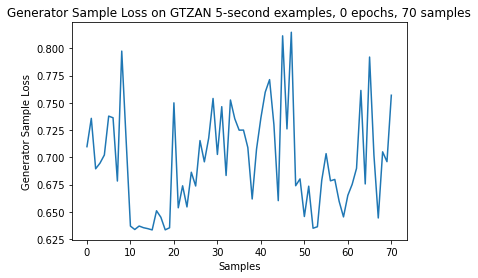

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


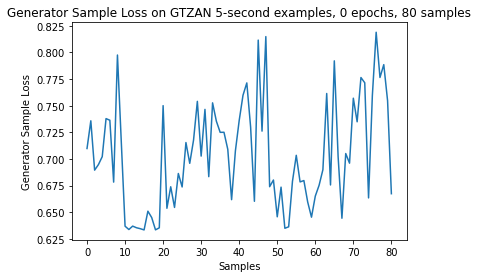

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


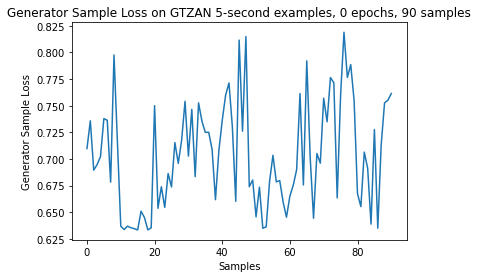

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100
Processing batch 1/100


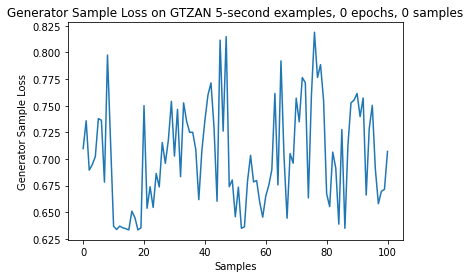

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


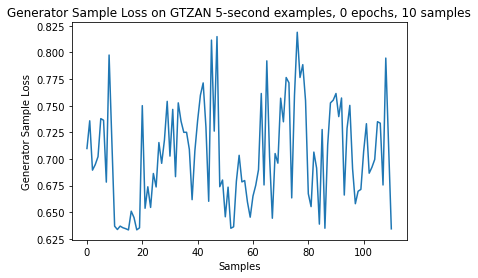

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


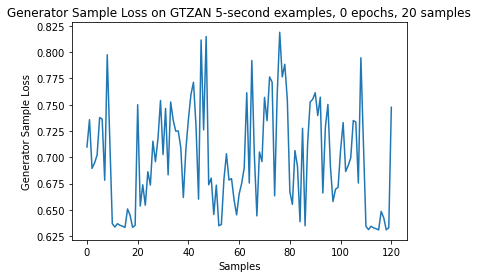

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


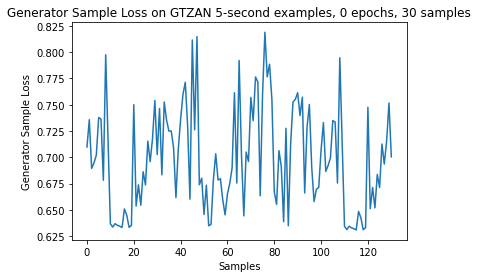

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


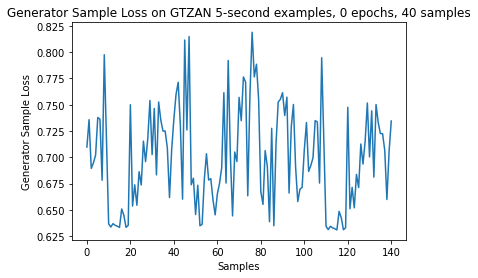

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


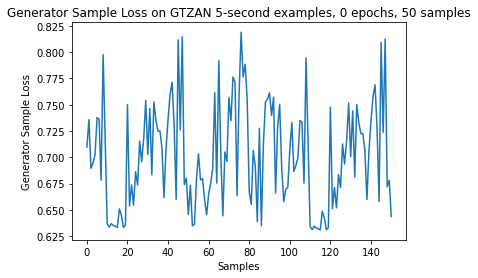

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


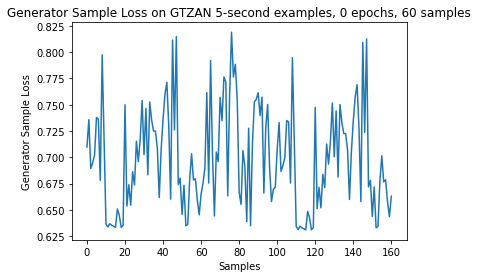

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


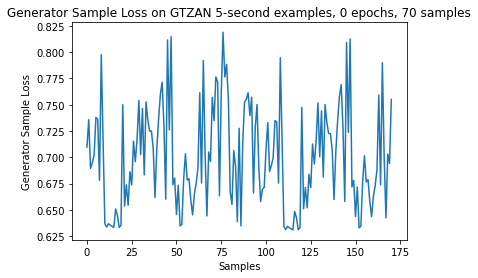

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


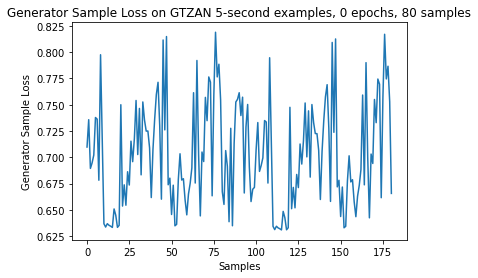

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


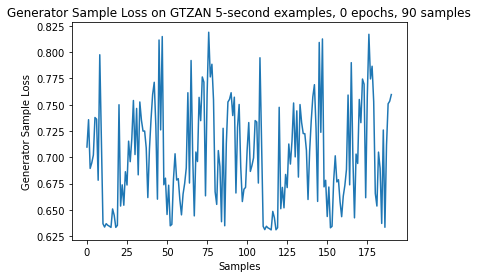

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100
Processing batch 1/100


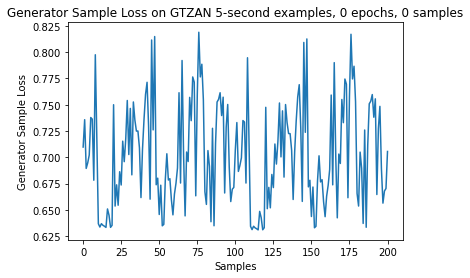

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


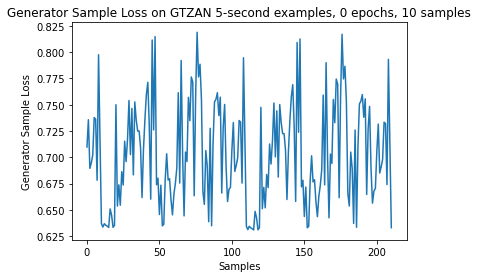

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


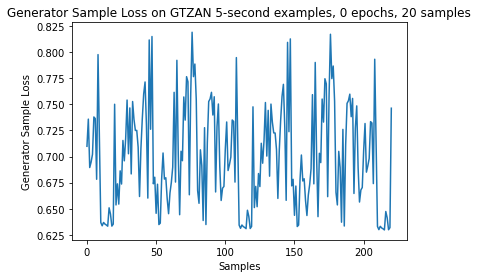

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


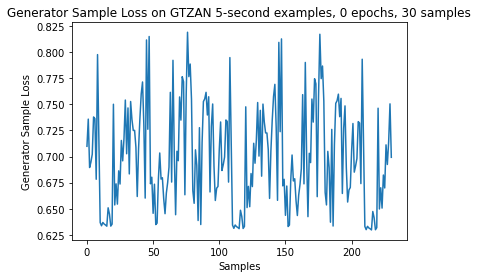

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


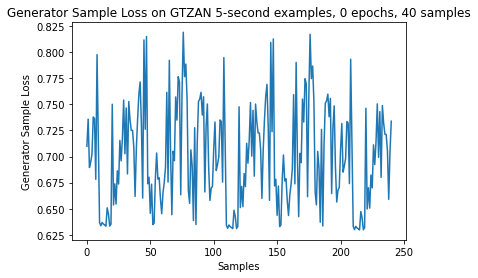

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


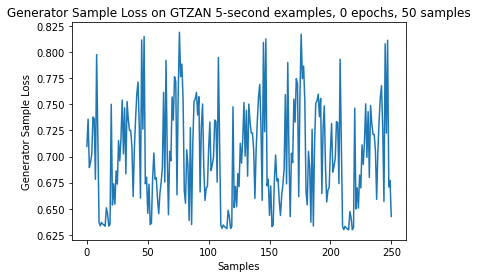

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


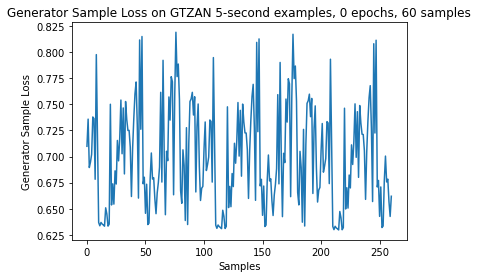

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


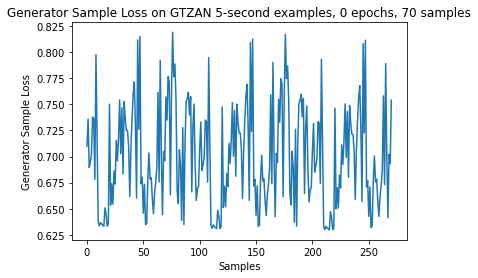

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


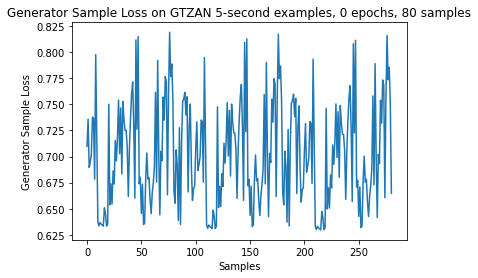

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


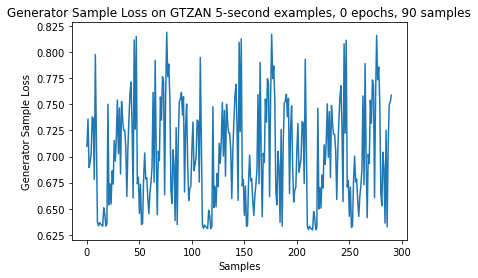

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100
Processing batch 1/100


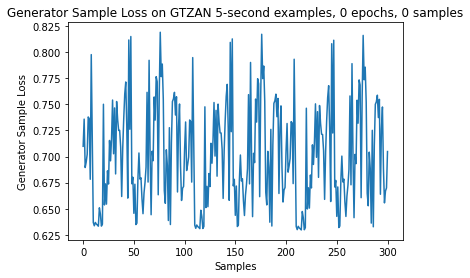

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


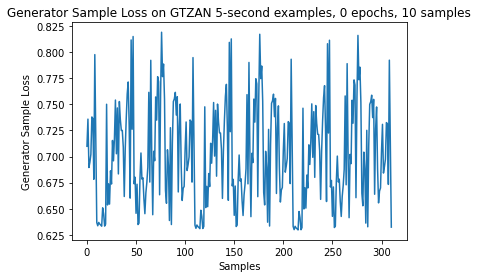

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


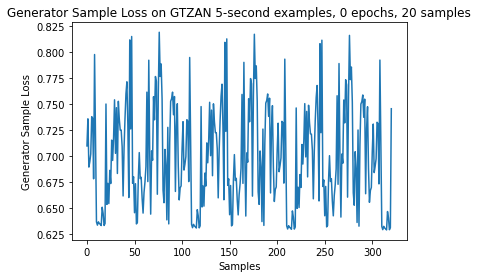

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


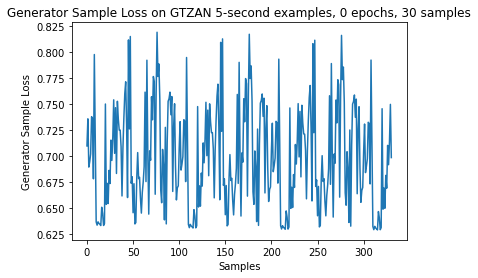

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


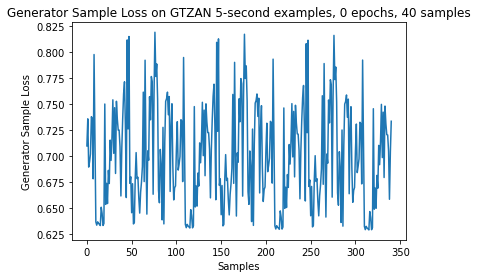

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


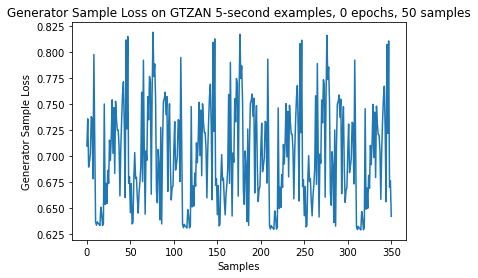

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


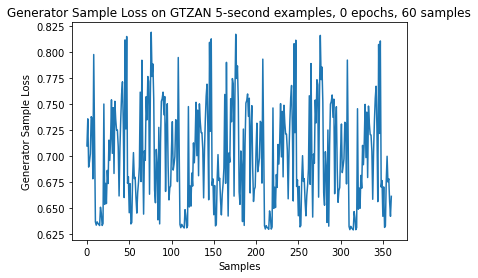

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


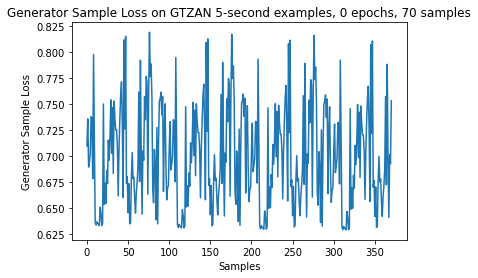

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


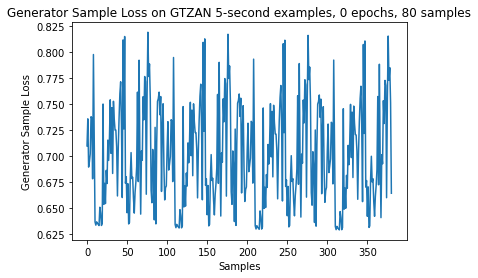

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


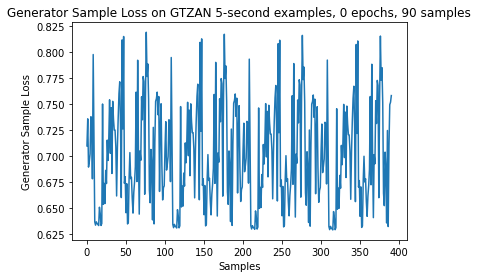

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100
Processing batch 1/100


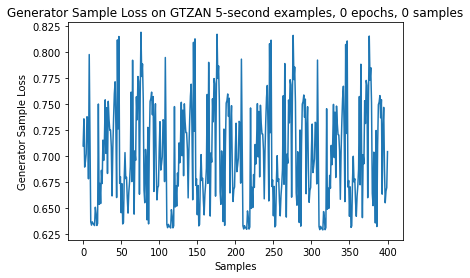

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


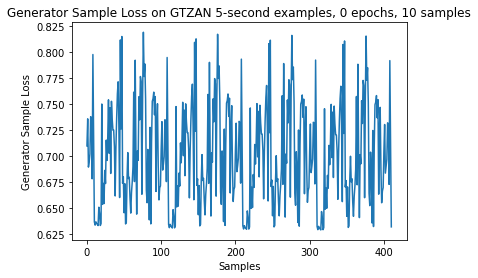

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


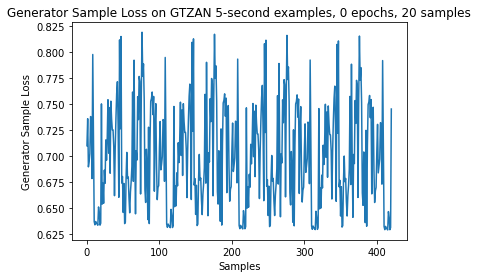

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


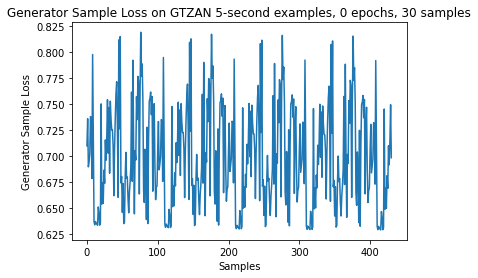

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


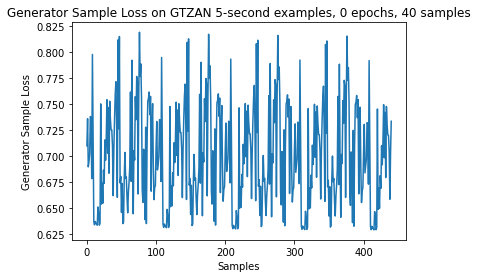

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


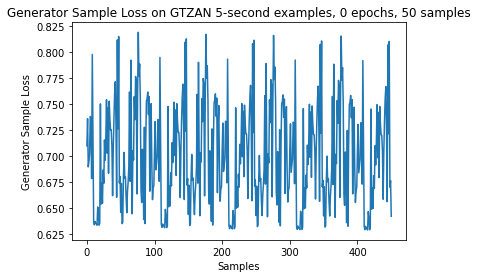

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


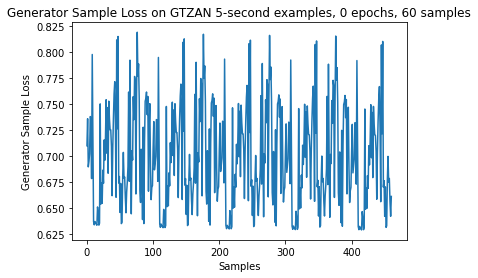

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


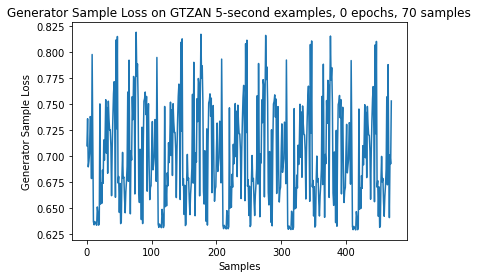

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


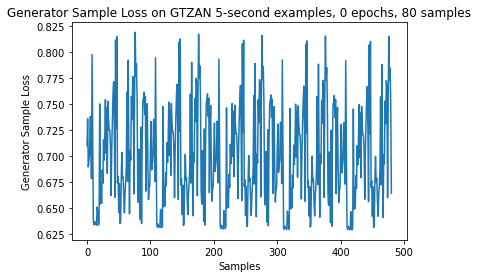

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


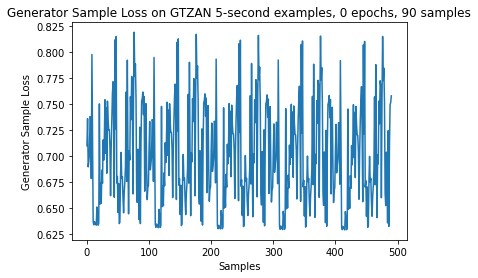

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100
Processing batch 100/100


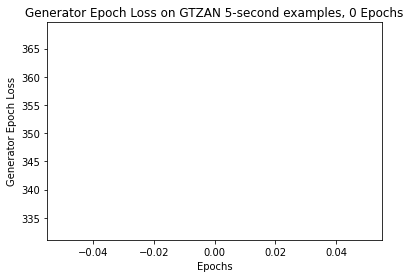

Epoch [0/10], generator loss: [350.3783828616142] discriminator loss: [69.56719416379929]
Epoch 1/10
Training Discriminator on real samples and fake reconstructed samples
Processing batch 1/100


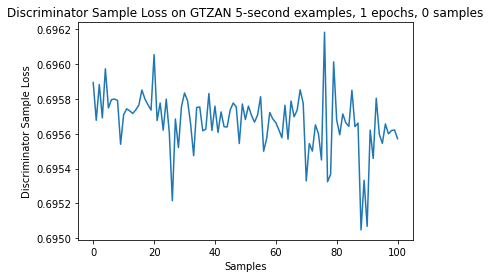

Processing batch 2/100
Processing batch 3/100
Processing batch 4/100
Processing batch 5/100
Processing batch 6/100
Processing batch 7/100
Processing batch 8/100
Processing batch 9/100
Processing batch 10/100
Processing batch 11/100


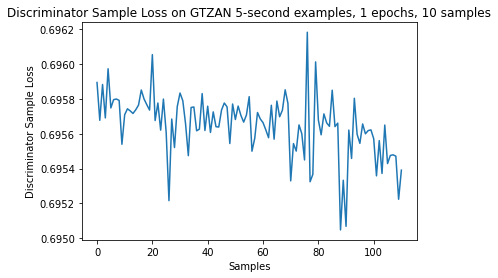

Processing batch 12/100
Processing batch 13/100
Processing batch 14/100
Processing batch 15/100
Processing batch 16/100
Processing batch 17/100
Processing batch 18/100
Processing batch 19/100
Processing batch 20/100
Processing batch 21/100


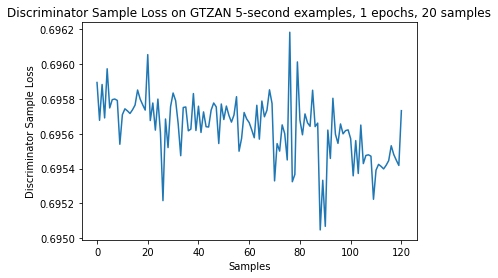

Processing batch 22/100
Processing batch 23/100
Processing batch 24/100
Processing batch 25/100
Processing batch 26/100
Processing batch 27/100
Processing batch 28/100
Processing batch 29/100
Processing batch 30/100
Processing batch 31/100


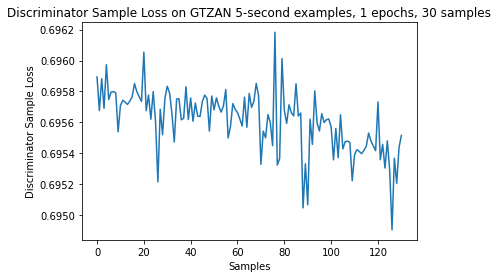

Processing batch 32/100
Processing batch 33/100
Processing batch 34/100
Processing batch 35/100
Processing batch 36/100
Processing batch 37/100
Processing batch 38/100
Processing batch 39/100
Processing batch 40/100
Processing batch 41/100


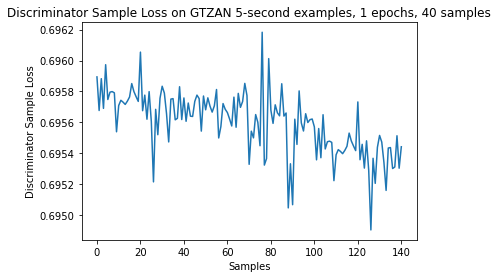

Processing batch 42/100
Processing batch 43/100
Processing batch 44/100
Processing batch 45/100
Processing batch 46/100
Processing batch 47/100
Processing batch 48/100
Processing batch 49/100
Processing batch 50/100
Processing batch 51/100


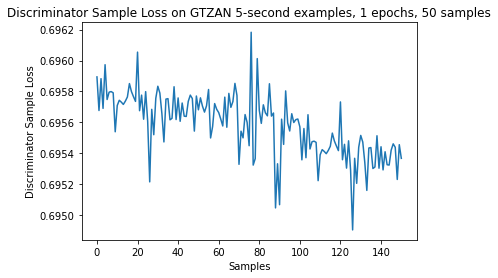

Processing batch 52/100
Processing batch 53/100
Processing batch 54/100
Processing batch 55/100
Processing batch 56/100
Processing batch 57/100
Processing batch 58/100
Processing batch 59/100
Processing batch 60/100
Processing batch 61/100


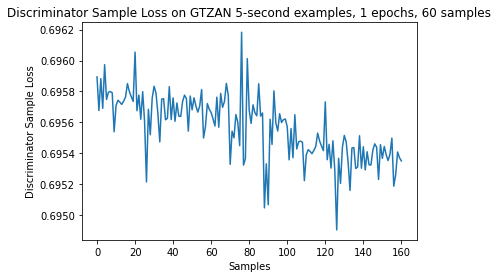

Processing batch 62/100
Processing batch 63/100
Processing batch 64/100
Processing batch 65/100
Processing batch 66/100
Processing batch 67/100
Processing batch 68/100
Processing batch 69/100
Processing batch 70/100
Processing batch 71/100


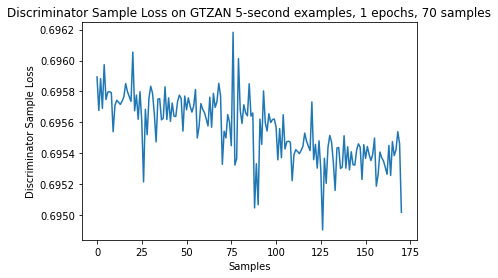

Processing batch 72/100
Processing batch 73/100
Processing batch 74/100
Processing batch 75/100
Processing batch 76/100
Processing batch 77/100
Processing batch 78/100
Processing batch 79/100
Processing batch 80/100
Processing batch 81/100


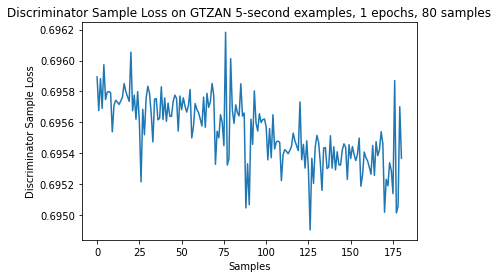

Processing batch 82/100
Processing batch 83/100
Processing batch 84/100
Processing batch 85/100
Processing batch 86/100
Processing batch 87/100
Processing batch 88/100
Processing batch 89/100
Processing batch 90/100
Processing batch 91/100


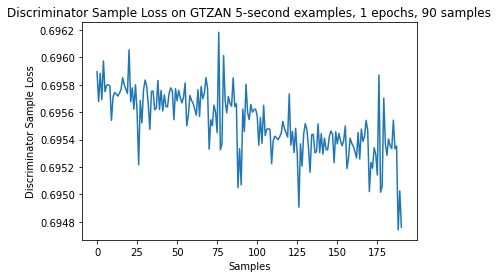

Processing batch 92/100
Processing batch 93/100
Processing batch 94/100
Processing batch 95/100
Processing batch 96/100
Processing batch 97/100
Processing batch 98/100
Processing batch 99/100


RuntimeError: can't start new thread

In [24]:
losses = {
    'generator': {
        'epoch': [],
        'sample': []
    },
    'discriminator': {
        'epoch': [],
        'sample': []
    }
}
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # Train Discriminator
    print("Training Discriminator on real samples and fake reconstructed samples")
    losses['discriminator']['epoch'].append(0)
    for idx, batch in enumerate(gtzan_loader):
        # Extract data
        print(f"Processing batch {idx+1}/{len(gtzan_loader)}")
        waveform, sample_rate, label = batch

        # Forward pass
        real = torch.transpose(waveform, 0, -1)
        real = torch.transpose(real, -2, -1)
        real = real[:SAMPLE_LENGTH,:,:].to(device)
        fake = generator(real).detach()
        
        # Get logits for both real and fake
        fake_logits = discriminator(fake)
        real_logits = discriminator(real)
        
        # Compute loss
        fake_loss = bce_loss(fake_logits, torch.zeros_like(fake_logits))
        real_loss = bce_loss(real_logits, torch.ones_like(real_logits))
        loss = (fake_loss + real_loss)/2
        losses['discriminator']['epoch'][-1] += loss.item()
        losses['discriminator']['sample'].append(loss.item())
        
        if idx % 10 == 0:
            plt.plot(losses['discriminator']['sample'])
            plt.ylabel('Discriminator Sample Loss')
            plt.xlabel('Samples')
            plt.title(f'Discriminator Sample Loss on GTZAN 5-second examples, {epoch} epochs, {idx} samples')
            plt.show()

            torch.save({
                "models": {
                    "generator": generator.state_dict(),
                    "discriminator": discriminator.state_dict()
                },
                "optimizers": {
                    "generator": gen_optimizer.state_dict(),
                    "discriminator": disc_optimizer.state_dict()
                },
                "hyperparameters": {
                    "epochs": EPOCHS,
                    "sample_rate": 22050,
                    "sample_length": SAMPLE_LENGTH,
                    "direct": IS_DIRECT,
                    "lr": D_LR,
                },
                "stage": "discriminator",
                "losses": losses,
                "epochs": epoch,
                "idx": idx
            }, f'./{RUN_NAME}.pt')
        
        # Apply optimization
        disc_optimizer.zero_grad()
        loss.backward()
        disc_optimizer.step()
        
    # Plot loss
    plt.plot(losses['discriminator']['epoch'])
    plt.ylabel('Discriminator Epoch Loss')
    plt.xlabel('Epochs')
    plt.title(f'Discriminator Epoch Loss on GTZAN 5-second examples, {epoch} Epochs')
    plt.show()
    
    # Train Generator
    losses['generator']['epoch'].append(0)
    for repetition in range(5):
        for idx, batch in enumerate(gtzan_loader):
            # Extract data
            print(f"Processing batch {idx+1}/{len(gtzan_loader)}")
            waveform, sample_rate, label = batch

            # Forward pass
            real = torch.transpose(waveform, 0, -1)
            real = torch.transpose(real, -2, -1)
            real = real[:SAMPLE_LENGTH,:,:].to(device)
            fake = generator(real)
            logits = discriminator(fake)

            if idx == 0:
                wav = real[:,0,:] # Get the first sample in the batch
                output = fake[:,0,:] # Get the first sample in the batch
                eq = RandomEQ(sample_rate)
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_original.wav',
                    torch.squeeze(torch.transpose(wav.to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_eqd.wav',
                    torch.squeeze(torch.transpose(eq(wav).to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )
                torchaudio.save(
                    f'EQ/{RUN_NAME}/sample_reconstructed_{epoch}.wav',
                    torch.squeeze(torch.transpose(output.to('cpu'), 0, 1), axis=-1),
                    sample_rate
                )

            # Compute and print loss
            loss = loss_function(fake, real, direct=IS_DIRECT)
            loss += bce_loss(logits, torch.ones_like(logits))

            losses['generator']['epoch'][-1] += loss.item()
            losses['generator']['sample'].append(loss.item())

            if idx % 10 == 0:
                plt.plot(losses['generator']['sample'])
                plt.ylabel('Generator Sample Loss')
                plt.xlabel('Samples')
                plt.title(f'Generator Sample Loss on GTZAN 5-second examples, {epoch} epochs, {idx} samples')
                plt.show()

                torch.save({
                    "models": {
                        "generator": generator.state_dict(),
                        "discriminator": discriminator.state_dict()
                    },
                    "optimizers": {
                        "generator": gen_optimizer.state_dict(),
                        "discriminator": disc_optimizer.state_dict()
                    },
                    "hyperparameters": {
                        "epochs": EPOCHS,
                        "sample_rate": 22050,
                        "sample_length": SAMPLE_LENGTH,
                        "direct": IS_DIRECT,
                        "lr": G_LR,
                    },
                    "stage": generator,
                    "losses": losses,
                    "epochs": epoch,
                    "idx": idx
                }, f'./{RUN_NAME}.pt')

            # Perform a backward pass, and update the weights.
            # Zero gradients
            gen_optimizer.zero_grad()
            loss.backward()
            gen_optimizer.step()

    # Plot loss
    plt.plot(losses['generator']['epoch'])
    plt.ylabel('Generator Epoch Loss')
    plt.xlabel('Epochs')
    plt.title(f'Generator Epoch Loss on GTZAN 5-second examples, {epoch} Epochs')
    plt.show()
    
    print(f"Epoch [{epoch}/{EPOCHS}], generator loss: {losses['generator']['epoch']} discriminator loss: {losses['discriminator']['epoch']}")

In [ ]:
checkpoint_path = f'./{RUN_NAME}.pt'

In [ ]:
def save_checkpoint(model, optimizer, path):
    torch.save({
        "model": model.state_dict(),
        "opt": optimizer.state_dict(),
        "hyperparameters": {
            "epochs": EPOCHS,
            "sample_rate": 22050,
            "sample_length": 110229,
            "direct": True,
            "lr": LR,
        },
        "losses": losses
    }, path)

In [ ]:
save_checkpoint(model, optimizer, checkpoint_path)

In [ ]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title(f'Epoch Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_epoch_loss.png')

In [ ]:
plt.plot(full_losses)
plt.ylabel('loss')
plt.xlabel('samples')
plt.title(f'Sample Loss on GTZAN 5-second examples, {EPOCHS} Epochs')
plt.savefig('gtzan_5_sec_10_epochs_sample_loss.png')